In [1]:
import syft as sy
import jax
from jax.example_libraries import stax
from jax import random
from jax.example_libraries.stax import Dense, Relu, LogSoftmax
import jax.numpy as jnp
from pprint import pprint
from mnist_dataset import mnist

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/dk/Desktop/projects/PySyft



Warning: syft is imported in light mode by default.         
To switch to dark mode, please run `sy.options.color_theme = 'dark'`

## 1. DS logins to the domain with the credentials created by the DO

In [2]:
node = sy.orchestra.launch(name="dk-domain", dev_mode=True)
ds_client = node.login(email="sheldon@caltech.edu", password="changethis")

SQLite Store Path:
!open file:///tmp/7394e1ec94664623a12883a6a2443efa.sqlite

Logged into dk-domain as GUEST
Logged into dk-domain as <sheldon@caltech.edu>


### Inspect the datasets on the domain

In [3]:
datasets = ds_client.datasets.get_all()
datasets

[syft.service.dataset.dataset.Dataset]

In [4]:
assets = datasets[0].assets
assets

TupleDict([('MNIST training images', syft.service.dataset.dataset.Asset),
           ('MNIST training labels', syft.service.dataset.dataset.Asset)])

In [5]:
training_images = assets[0]
training_images

syft.service.dataset.dataset.Asset

In [6]:
training_labels = assets[1]
training_labels

syft.service.dataset.dataset.Asset

#### The DS can not access the real data

In [7]:
training_images.data

'Permission: <READ: 61f2a350f09a482bb07becd54427ec72 as 5e96468cb5fba37b07ec4726672fcf4e6bc3ed81226ce7dae4af8de87c799ab3> denied'

#### The DS can only access the mock data, which is some random noise

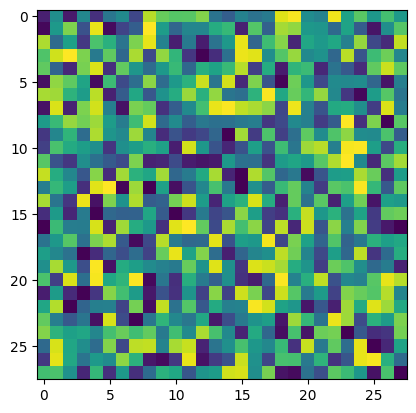

In [8]:
mock_images = training_images.mock

import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.reshape(mock_images[0], (28, 28)))

#### We need the pointers to the mock data to construct a `syft` function (later in the notebook)

In [9]:
mock_images_ptr = training_images.pointer
mock_images_ptr

```python
TwinPointer(Mock)
```
array([[0.08873336, 0.494534  , 0.06747154, ..., 0.05032806, 0.71233182,
        0.00636383],
       [0.07964206, 0.48961752, 0.6191658 , ..., 0.45047321, 0.19557278,
        0.09499248],
       [0.48086514, 0.26512912, 0.59760265, ..., 0.81390115, 0.04661275,
        0.62467362],
       ...,
       [0.78769772, 0.41856213, 0.60080171, ..., 0.94222722, 0.45540055,
        0.86551167],
       [0.57958977, 0.64089569, 0.31409525, ..., 0.83908015, 0.59407235,
        0.44268975],
       [0.86192919, 0.48110916, 0.35221101, ..., 0.20024298, 0.17936181,
        0.6885182 ]])

In [10]:
type(mock_images_ptr)

syft.service.action.numpy.NumpyArrayObject

In [11]:
mock_labels = training_labels.mock
mock_labels_ptr = training_labels.pointer
mock_labels_ptr

```python
TwinPointer(Mock)
```
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

## 2. The DS prepare the training code and experiment on the mock data

In [12]:
def mnist_3_linear_layers(mnist_images, mnist_labels):
    # import the packages
    import jax
    from jax.example_libraries import stax
    from jax.example_libraries.stax import Dense, Relu, LogSoftmax
    import time
    from jax.example_libraries import optimizers
    import itertools
    import jax.numpy as jnp
    import numpy.random as npr
    from jax import jit, grad, random
    
    # define the neural network
    init_random_params, predict = stax.serial(
        Dense(1024), Relu,
        Dense(1024), Relu,
        Dense(10), LogSoftmax)
    
    # initialize the random parameters
    rng = random.PRNGKey(0)
    _, init_params = init_random_params(rng, (-1, 784))
    
    # the hyper parameters
    num_epochs = 10
    batch_size = 4
    num_train = mnist_images.shape[0]
    num_complete_batches, leftover = divmod(num_train, batch_size)
    num_batches = num_complete_batches + bool(leftover)
    step_size = 0.001
    momentum_mass = 0.9
    
    # initialize the optimizer
    opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)
    opt_state = opt_init(init_params)
    itercount = itertools.count()

    @jit
    def update(i, opt_state, batch):
        params = get_params(opt_state)
        return opt_update(i, grad(loss)(params, batch), opt_state)
    
    def data_stream():
        """
        Create a batch of data picked randomly 
        """
        rng = npr.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield mnist_images[batch_idx], mnist_labels[batch_idx]
        
    def loss(params, batch):
        inputs, targets = batch
        preds = predict(params, inputs)
        return -jnp.mean(jnp.sum(preds * targets, axis=1))


    def accuracy(params, batch):
        inputs, targets = batch
        target_class = jnp.argmax(targets, axis=1)
        predicted_class = jnp.argmax(predict(params, inputs), axis=1)
        return jnp.mean(predicted_class == target_class)
    
    batches = data_stream()
    train_accs = []
    print("\nStarting training...")
    for epoch in range(num_epochs):
        start_time = time.time()
        for _ in range(num_batches):
            opt_state = update(next(itercount), opt_state, next(batches))
        epoch_time = time.time() - start_time
        params = get_params(opt_state)
        train_acc = accuracy(params, (mnist_images, mnist_labels))
        print(f"Epoch {epoch} in {epoch_time:0.2f} sec")
        print(f"Training set accuracy {train_acc}")
        train_accs.append(train_acc)
    
    return train_accs, params

In [13]:
train_accs, params = mnist_3_linear_layers(mnist_images=mock_images, mnist_labels=mock_labels)


Starting training...
Epoch 0 in 2.00 sec
Training set accuracy 0.15700000524520874
Epoch 1 in 1.81 sec
Training set accuracy 0.23900000751018524
Epoch 2 in 1.81 sec
Training set accuracy 0.34700000286102295
Epoch 3 in 1.82 sec
Training set accuracy 0.2580000162124634
Epoch 4 in 1.86 sec
Training set accuracy 0.5550000071525574
Epoch 5 in 1.80 sec
Training set accuracy 0.45100003480911255
Epoch 6 in 1.75 sec
Training set accuracy 0.6100000143051147
Epoch 7 in 1.80 sec
Training set accuracy 0.7460000514984131
Epoch 8 in 1.87 sec
Training set accuracy 0.812000036239624
Epoch 9 in 1.88 sec
Training set accuracy 0.7970000505447388


In [14]:
train_accs

[Array(0.157, dtype=float32),
 Array(0.23900001, dtype=float32),
 Array(0.347, dtype=float32),
 Array(0.25800002, dtype=float32),
 Array(0.555, dtype=float32),
 Array(0.45100003, dtype=float32),
 Array(0.61, dtype=float32),
 Array(0.74600005, dtype=float32),
 Array(0.81200004, dtype=float32),
 Array(0.79700005, dtype=float32)]

In [15]:
# shape of the model's parameters
jax.tree_map(lambda x: x.shape, params)

[((784, 1024), (1024,)),
 (),
 ((1024, 1024), (1024,)),
 (),
 ((1024, 10), (10,)),
 ()]

## 3. Now that the code works on mock data, the DS submits the code request for execution to the DO

#### First the DS wraps the training function with the `@sy.syft_function` decorator

In [16]:
@sy.syft_function(input_policy=sy.ExactMatch(mnist_images=mock_images_ptr, mnist_labels=mock_labels_ptr),
                  output_policy=sy.SingleExecutionExactOutput())
def mnist_3_linear_layers(mnist_images, mnist_labels):
    # import the packages
    import jax
    from jax.example_libraries import stax
    from jax.example_libraries.stax import Dense, Relu, LogSoftmax
    import time
    from jax.example_libraries import optimizers
    import itertools
    import jax.numpy as jnp
    import numpy.random as npr
    from jax import jit, grad, random
    
    # define the neural network
    init_random_params, predict = stax.serial(
        Dense(1024), Relu,
        Dense(1024), Relu,
        Dense(10), LogSoftmax)
    
    # initialize the random parameters
    rng = random.PRNGKey(0)
    _, init_params = init_random_params(rng, (-1, 784))
    
    # the hyper parameters
    num_epochs = 10
    batch_size = 4
    num_train = mnist_images.shape[0]
    num_complete_batches, leftover = divmod(num_train, batch_size)
    num_batches = num_complete_batches + bool(leftover)
    step_size = 0.001
    momentum_mass = 0.9
    
    # initialize the optimizer
    opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)
    opt_state = opt_init(init_params)
    itercount = itertools.count()

    @jit
    def update(i, opt_state, batch):
        params = get_params(opt_state)
        return opt_update(i, grad(loss)(params, batch), opt_state)
    
    def data_stream():
        """
        Create a batch of data picked randomly 
        """
        rng = npr.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield mnist_images[batch_idx], mnist_labels[batch_idx]
        
    def loss(params, batch):
        inputs, targets = batch
        preds = predict(params, inputs)
        return -jnp.mean(jnp.sum(preds * targets, axis=1))


    def accuracy(params, batch):
        inputs, targets = batch
        target_class = jnp.argmax(targets, axis=1)
        predicted_class = jnp.argmax(predict(params, inputs), axis=1)
        return jnp.mean(predicted_class == target_class)
    
    batches = data_stream()
    train_accs = []
    print("\nStarting training...")
    for epoch in range(num_epochs):
        start_time = time.time()
        for _ in range(num_batches):
            opt_state = update(next(itercount), opt_state, next(batches))
        epoch_time = time.time() - start_time
        params = get_params(opt_state)
        train_acc = accuracy(params, (mnist_images, mnist_labels))
        print(f"Epoch {epoch} in {epoch_time:0.2f} sec")
        print(f"Training set accuracy {train_acc}")
        train_accs.append(train_acc)

    return train_accs, params

#### Then the DS creates a new project with relevant name and description, as well as specify itself as a member of the project

In [17]:
new_project = sy.Project(
    name="Training a 3-layer jax neural network on MNIST data",
    description="""Hi, I would like to train my neural network on your MNIST data 
                (I can download it online too but I just want to use Syft coz it's cool)""",
    members=[ds_client],
) 
new_project

syft.service.project.project.ProjectSubmit

#### Add a code request to the project

In [18]:
new_project.create_code_request(obj=mnist_3_linear_layers, client=ds_client)

<class 'syft.service.response.SyftSuccess'>: Request added successfully

In [19]:
ds_client.code

#### Start the project which will notifies the DO

In [20]:
project = new_project.start()

In [21]:
project.events

[syft.service.project.project.ProjectRequest]

In [22]:
project.requests

[syft.service.request.request.Request]

In [23]:
project.requests[0]

syft.service.request.request.Request

### 📓 Now switch back to the DO's notebook

## 4. After the DO has ran the code and deposited the results, the DS gets them

In [24]:
ds_client.code

In [25]:
project.requests

[syft.service.request.request.Request]

In [26]:
result = ds_client.code.mnist_3_linear_layers(mnist_images=training_images, mnist_labels=training_labels)

In [27]:
result

Pointer:
ActionDataEmpty UID: 4e140c3f9cc84683a0bd332640571ac2 <None>

In [28]:
train_accs, params = result.get_from(ds_client)

In [29]:
pprint(train_accs)

[Array(0.82900006, dtype=float32),
 Array(0.88400006, dtype=float32),
 Array(0.92, dtype=float32),
 Array(0.93700004, dtype=float32),
 Array(0.95300007, dtype=float32),
 Array(0.96700007, dtype=float32),
 Array(0.97700006, dtype=float32),
 Array(0.97800004, dtype=float32),
 Array(0.99000007, dtype=float32),
 Array(0.99700004, dtype=float32)]


In [30]:
jax.tree_map(lambda x: x.shape, params)

[((784, 1024), (1024,)),
 (),
 ((1024, 1024), (1024,)),
 (),
 ((1024, 10), (10,)),
 ()]

## 5. The DS gets the trained weights and do inference on the MNIST test dataset

In [31]:
_, _, test_images, test_labels = mnist()

In [32]:
print(f"{test_images.shape = }")
print(f"{test_labels.shape = }")

test_images.shape = (10000, 784)
test_labels.shape = (10000, 10)


In [33]:
# define the neural network
init_random_params, predict = stax.serial(
    Dense(1024), Relu,
    Dense(1024), Relu,
    Dense(10), LogSoftmax)

In [34]:
def accuracy(params, batch):
    inputs, targets = batch
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(predict(params, inputs), axis=1)
    return jnp.mean(predicted_class == target_class)

#### Test inference using random weights

In [39]:
rng = random.PRNGKey(0)
_, random_params = init_random_params(rng, (-1, 28 * 28))

test_acc = accuracy(random_params, (test_images, test_labels))
print(f"Test set accuracy with random weights {test_acc * 100 : .2f}%")

Test set accuracy with random weights  8.68%


#### Test inference using the trained weights recevied from the DO

In [40]:
test_acc = accuracy(params, (test_images, test_labels))
print(f"Test set accuracy with trained weights {test_acc * 100 : .2f}%")

Test set accuracy with trained weights  88.08%
